In [1]:
from vampyr import vampyr3d as vp
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scipy.integrate as integrate
from scipy.special import legendre, laguerre, erf, gamma
from scipy.special import gamma
from scipy.constants import hbar

mra = vp.MultiResolutionAnalysis(box=[-20,20], order=7)
prec = 1.0e-4
origin = [0.1, 0.2, 0.3]

print(mra)

                    MultiResolution Analysis                    
----------------------------------------------------------------
 polynomial order      : 7
 polynomial type       : Interpolating
----------------------------------------------------------------
 total boxes           : 8
 boxes                 : [          2           2           2 ]
 unit lengths          : [  20.000000   20.000000   20.000000 ]
 scaling factor        : [   1.250000    1.250000    1.250000 ]
 lower bounds          : [ -20.000000  -20.000000  -20.000000 ]
 upper bounds          : [  20.000000   20.000000   20.000000 ]
 total length          : [  40.000000   40.000000   40.000000 ]



In [2]:
# He atom questa parte da rivedere
# Normalization not considered
# Exponential coeffcient C=1 (wikipedia coeff is not compatible with eigensolution)
# Limited to ground state for now (some formulas are however more generic)
# So far the best general description for the 4-c H atom was in the Bethe&Salpeter book

c=137.035999
alpha = 1.0/c
k = -1
l = 0
n = 1
m = 0.5
Z = 2


def compute_norm_const(n, gamma_factor):
# THIS NORMALIZATION CONSTANT IS FROM WIKIPEDIA BUT IT DOES NOT AGREE WITH Bethe&Salpeter
    tmp1 = 2 * n * (n + gamma_factor)
    tmp2 = 1 / (gamma_factor * gamma(2 * gamma_factor))
    return np.sqrt(tmp2/tmp1)



0.5015646537241815 -50.13357312388721


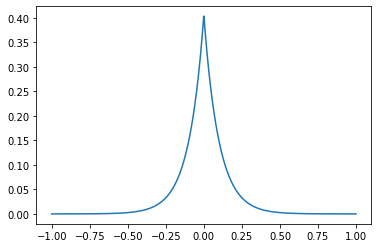

In [3]:
def J_coulomb_n(phi_n,mra):
    pua = vp.PoissonOperator(mra,prec=0.00001)
    n = phi_n*phi_n
    pua_n = pua(n)
    return pua_n*(4*np.pi)

def compute_gamma(k,Z,alpha):
    return np.sqrt(k**2 - Z**2 * alpha**2)

def compute_dirac_energy(n,Z,k,alpha):
    gamma_factor = compute_gamma(k,Z,alpha)
    tmp1 = n - np.abs(k) + gamma_factor
    tmp2 = Z * alpha / tmp1
    tmp3 = 1 + tmp2**2
    return c**2 / np.sqrt(tmp3)

def one_s_alpha(x,Z,alpha,gamma_factor):
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    tmp1 = 1.0 + gamma_factor
    tmp4 = Z * alpha
    u = x/r
    lar =   tmp1
    sai =   tmp4 * u[2]
    sbr = - tmp4 * u[1]
    sbi =   tmp4 * u[0]
    return lar, 0, 0, 0, 0, sai, sbr, sbi

def one_s_alpha_comp(x,Z,alpha,gamma_factor,norm_const,comp):
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    tmp2 = r ** (gamma_factor - 1)
    tmp3 = np.exp(-Z*r)
    values = one_s_alpha(x,Z,alpha,gamma_factor)
    return values[comp] * tmp2 * tmp3 * norm_const / np.sqrt(2*np.pi)
                
gamma_factor = compute_gamma(k,Z,alpha)
norm_const = compute_norm_const(n, gamma_factor)
energy = compute_dirac_energy(n,Z,k,alpha)
Ezora = 2*(energy-c**2)*c**2/(energy+c**2)
print(norm_const,Ezora)

x_plt = np.linspace(-1.0, 1.0, 1000)
y_plt = [one_s_alpha_comp([x,0.0,0.0],Z,alpha,gamma_factor,norm_const,0) for x in x_plt]
_ = plt.plot(x_plt, y_plt)


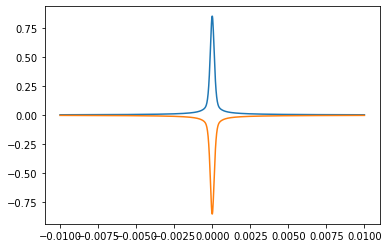

In [4]:
def u(r):
    u = erf(r)/r + (1/(3*np.sqrt(np.pi)))*(np.exp(-(r**2)) + 16*np.exp(-4*r**2))
    #erf(r) is an error function that is supposed to stop the potential well from going to inf.
    #if i remember correctly
    return u

def V(x):
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
#    c = 0.0435
    c = 0.000435 # ten times tighter nuclear potential
    f_bar = u(r/c)/c
    return f_bar

def kappa(x):
    temp = V(x) / (2 * c**2)
    return 1.0/(1-temp)

def one_m_kappa(x):
    temp = (2 * c**2) / V(x)
    return 1.0/(1-temp)

x_plt = np.linspace(-0.01, 0.01, 1000)
y1_plt = [kappa([x, 0.0, 0.0])-1 for x in x_plt]
y2_plt = [one_m_kappa([x, 0.0, 0.0]) for x in x_plt]
plt.plot(x_plt, y1_plt)
plt.plot(x_plt, y2_plt)

In [5]:
Peps = vp.ScalingProjector(mra,prec)
f = lambda x: V([x[0]-origin[0],x[1]-origin[1],x[2]-origin[2]])

print(f([0.5,0.5,0.5]))
V_tree = Z*Peps(f)

1.8569533817705184


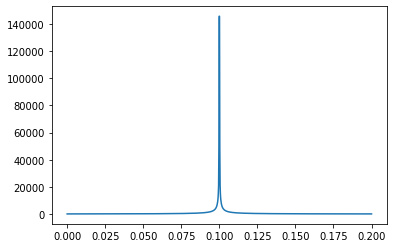

In [6]:
x_plt = np.linspace(0.0, 0.20, 1000)
nuclear_potential_plt = [V_tree([x, 0.2, 0.3]) for x in x_plt]
plt.plot(x_plt, nuclear_potential_plt)

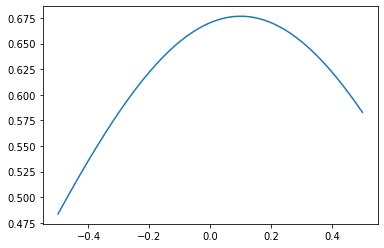

In [7]:
a_coeff = 3.0
b_coeff = np.sqrt(a_coeff/np.pi)**3
gauss = vp.GaussFunc(b_coeff, a_coeff, origin)
gauss_tree = vp.FunctionTree(mra)
vp.advanced.build_grid(out=gauss_tree, inp=gauss)
vp.advanced.project(prec=prec, out=gauss_tree, inp=gauss)
gauss_tree.normalize()

x_plt = np.linspace(-0.5, 0.5, 1000)
y_plt = [gauss_tree([x, 0.2, 0.3]) for x in x_plt]
plt.plot(x_plt, y_plt)

Energy  -1.1123261789933327 0.41232617899333285
Energy  -1.9219430578502839 0.8096168788569512
Energy  -3.6763647421149717 1.7544216842646876
Energy  -5.6712495719771425 1.9948848298621704
Energy  -10.247896965447824 4.576647393470681
Energy  -20.03403932840443 9.786142362956605
Energy  -37.49563235991907 17.46159303151464
Energy  -45.91794809398547 8.422315734066403
Energy  -51.308101080849895 5.3901529868644245
Energy  -54.10215939442978 2.794058313579891
Energy  -55.38492922122408 1.2827698267942966
Energy  -55.94561396495829 0.5606847437342127
Energy  -56.19291417146892 0.2473002065106317
Energy  -56.30658676341554 0.11367259194661788
Energy  -56.361386920893466 0.05480015747792883
Energy  -56.38885899776519 0.027472076871726477
Energy  -56.403006778825976 0.014147781060788232
Energy  -56.41041565020969 0.007408871383718104
Energy  -56.41433395058848 0.00391830037878504
Energy  -56.416417916498936 0.002083965910456138
Energy  -56.417529820352804 0.0011119038538673681
Energy  -56.41

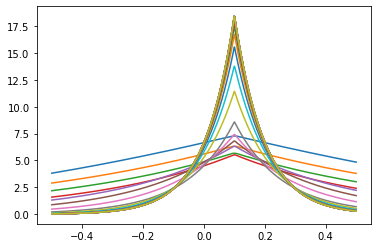

In [9]:
energy = -0.70;
energy_correction = 1.0;

phi_n = vp.FunctionTree(mra)
vp.advanced.copy_grid(phi_n, gauss_tree)
vp.advanced.copy_func(phi_n, gauss_tree)
phi_n.normalize()
#print(phi_n)

while np.abs(energy_correction) > prec/10:
    phi_n.normalize()
    phi_np1 = vp.FunctionTree(mra)
    temp1_tree = (V_tree + J_coulomb_n(phi_n,mra)) * phi_n
    
    mu = np.sqrt(-2*energy)
    
    pua = vp.PoissonOperator(mra,prec=0.00001)
    n = phi_n * phi_n
    pua_n = pua(n)*(4*np.pi)

    H = vp.HelmholtzOperator(mra, mu, prec)
    phi_np1 = 2 * H(temp1_tree)
    delta_phi = vp.FunctionTree(mra)
    vp.advanced.add(prec/10, delta_phi, 1.0, phi_np1, -1.0, phi_n)
    temp2_tree = delta_phi * (V_tree + J_coulomb_n(phi_n,mra))
    
    energy_correction = vp.dot(phi_np1, temp2_tree)/phi_np1.squaredNorm()
    phi_n = vp.FunctionTree(mra)
    vp.advanced.copy_grid(phi_n, phi_np1)
    vp.advanced.copy_func(phi_n, phi_np1)

    phi_n_plt = [phi_n([x, origin[1], origin[2]]) for x in x_plt]
    plt.plot(x_plt, phi_n_plt)

    while abs(energy_correction) > abs(energy): 
        energy_correction /= 2
    
    energy -= energy_correction
    print("Energy ", energy, energy_correction)

In [ ]:
exact_orbital = init_1s_orbital(k,Z,alpha,origin)

In [ ]:
normalize_orbital(exact_orbital)
print(exact_orbital['Lar']([0.1,0.2,0.3]))

In [ ]:
gaussian_orbital = init_empty_orbital()
init_large_components(gaussian_orbital,gauss_tree)
init_small_components(gaussian_orbital)
normalize_orbital(gaussian_orbital)
density = compute_density(gaussian_orbital)
x_plt = np.linspace(-1.0, 1.0, 1000)
density_plt = [density([x, 0.2, 0.3]) for x in x_plt]
_ = plt.plot(x_plt, density_plt)

In [ ]:
orbital = gaussian_orbital
orbital_error = 1
while orbital_error > prec:
#for i in range(2):    
    hd_psi = apply_dirac_hamiltonian(orbital)
    v_psi = apply_potential(V_tree, orbital)
    add_psi = add_orbitals(1.0, hd_psi, 1.0, v_psi)
    energy, imag = scalar_product(orbital, add_psi)
    print('Energy',energy)
    tmp = apply_helmholtz(v_psi, energy, c, prec)
    new_orbital = apply_dirac_hamiltonian(tmp, energy)
    normalize_orbital(new_orbital)
    delta_psi = add_orbitals(1.0, new_orbital, -1.0, orbital)
    orbital_error, imag = scalar_product(delta_psi, delta_psi)
    print('Error',orbital_error)
    orbital = new_orbital
    

hd_psi = apply_dirac_hamiltonian(orbital)
v_psi = apply_potential(V_tree, orbital)
add_psi = add_orbitals(1.0, hd_psi, 1.0, v_psi)
energy, imag = scalar_product(orbital, add_psi)
print('Energy',energy)

In [ ]:
v_psi = apply_potential(V_tree, gaussian_orbital)
tmp = apply_dirac_hamiltonian(v_psi, energy)
out_orb = apply_helmholtz(tmp, energy, c, prec)
normalize_orbital(out_orb)

In [ ]:
#for comp, func in add_psi.items():
#    if (func.getSquareNorm() > 0):
#        refine_grid(func,1)

fig, axs = plt.subplots(2,2,figsize=(10, 10))
#axs[0,0].set_box_aspect(1)
#axs[0,1].set_box_aspect(1)
#axs[1,0].set_box_aspect(1)
#axs[1,1].set_box_aspect(1)
x_plt = np.linspace(-1, 1, 1000)
orbital_plt = {}
exact_plt = {}
out_plt = {}
orb_plt = {}
add_psi_plt = {}
exact_plt['Lar']   = [exact_orbital['Lar'](   [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
exact_plt['Sai']   = [exact_orbital['Sai'](   [  origin[0],   origin[1], x+origin[2]]) for x in x_plt]
exact_plt['Sbr']   = [exact_orbital['Sbr'](   [  origin[0], x+origin[1],   origin[2]]) for x in x_plt]
exact_plt['Sbi']   = [exact_orbital['Sbi'](   [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
out_plt['Lar']     = [out_orb['Lar'](         [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
out_plt['Sai']     = [out_orb['Sai'](         [  origin[0],   origin[1], x+origin[2]]) for x in x_plt]
out_plt['Sbr']     = [out_orb['Sbr'](         [  origin[0], x+origin[1],   origin[2]]) for x in x_plt]
out_plt['Sbi']     = [out_orb['Sbi'](         [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
orb_plt['Lar']     = [orbital['Lar'](         [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
orb_plt['Sai']     = [orbital['Sai'](         [  origin[0],   origin[1], x+origin[2]]) for x in x_plt]
orb_plt['Sbr']     = [orbital['Sbr'](         [  origin[0], x+origin[1],   origin[2]]) for x in x_plt]
orb_plt['Sbi']     = [orbital['Sbi'](         [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
orbital_plt['Lar'] = [gaussian_orbital['Lar']([x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
orbital_plt['Sai'] = [gaussian_orbital['Sai']([  origin[0],   origin[1], x+origin[2]]) for x in x_plt]
orbital_plt['Sbr'] = [gaussian_orbital['Sbr']([  origin[0], x+origin[1],   origin[2]]) for x in x_plt]
orbital_plt['Sbi'] = [gaussian_orbital['Sbi']([x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
add_psi_plt['Lar'] = [add_psi['Lar'](         [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
add_psi_plt['Sai'] = [add_psi['Sai'](         [  origin[0],   origin[1], x+origin[2]]) for x in x_plt]
add_psi_plt['Sbr'] = [add_psi['Sbr'](         [  origin[0], x+origin[1],   origin[2]]) for x in x_plt]
add_psi_plt['Sbi'] = [add_psi['Sbi'](         [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
#plt.plot(x_plt, [add_psi_plt['Lar'][i]/orbital_plt['Lar'][i] for i in range(1000)])
#axs[0,0].plot(x_plt, add_psi_plt['Lar'],label='add_psi')
#axs[0,0].plot(x_plt, orbital_plt['Lar'],label='gaussian')
axs[0,0].plot(x_plt, exact_plt['Lar'],label='exact')
#axs[0,0].plot(x_plt, out_plt['Lar'],label='out (1 iter)')
axs[0,0].plot(x_plt, orb_plt['Lar'],label='out (err 10^-4)')
axs[0,0].legend()
#axs[0,1].plot(x_plt, add_psi_plt['Sai'],label='add_psi')
#axs[0,1].plot(x_plt, orbital_plt['Sai'],label='gaussian')
axs[0,1].plot(x_plt, exact_plt['Sai'],label='exact')
#axs[0,1].plot(x_plt, out_plt['Sai'],label='out (1 iter)')
axs[0,1].plot(x_plt, orb_plt['Sai'],label='out (err 10^-4)')
axs[0,1].legend()
#axs[1,0].plot(x_plt, add_psi_plt['Sbr'],label='add_psi')
#axs[1,0].plot(x_plt, orbital_plt['Sbr'],label='gaussian')
axs[1,0].plot(x_plt, exact_plt['Sbr'],label='exact')
#axs[1,0].plot(x_plt, out_plt['Sbr'],label='out (1 iter)')
axs[1,0].plot(x_plt, orb_plt['Sbr'],label='out (err 10^-4)')
axs[1,0].legend()
#axs[1,1].plot(x_plt, add_psi_plt['Sbi'],label='add_psi')
#axs[1,1].plot(x_plt, orbital_plt['Sbi'],label='gaussian')
axs[1,1].plot(x_plt, exact_plt['Sbi'],label='exact')
#axs[1,1].plot(x_plt, out_plt['Sbi'],label='out (1 iter)')
axs[1,1].plot(x_plt, orb_plt['Sbi'],label='out (err 10^-4)')
axs[1,1].legend()
#axs[0,0].set_ylim(0, 1)
#axs[0,1].set_ylim(-0.01, 0.01)
#axs[1,0].set_ylim(-0.01, 0.01)
#axs[1,1].set_ylim(-0.01, 0.01)
#plt.plot(x_plt, y_plt)

In [ ]:
hd_psi = apply_dirac_hamiltonian(orbital)
v_psi = apply_potential(V_tree, orbital)
add_psi = add_orbitals(1.0, hd_psi, 1.0, v_psi)
energy, imag = scalar_product(orbital, add_psi)
print('Converged energy',energy-c**2)
print(orbital['Lar']([0.1,0.2,0.3]))

In [ ]:
hd_psi = apply_dirac_hamiltonian(exact_orbital)
v_psi = apply_potential(V_tree, exact_orbital)
add_psi = add_orbitals(1.0, hd_psi, 1.0, v_psi)
energy, imag = scalar_product(exact_orbital, add_psi)
print('Exact energy',energy-c**2)
print("Analytical energy", compute_dirac_energy(n,Z,k,alpha)-c**2)
print(exact_orbital['Lar']([0.1,0.2,0.3]))

In [ ]:
hd_psi = apply_dirac_hamiltonian(gaussian_orbital)
v_psi = apply_potential(V_tree, gaussian_orbital)
add_psi = add_orbitals(1.0, hd_psi, 1.0, v_psi)
energy, imag = scalar_product(gaussian_orbital, add_psi)
print('Starting guess energy',energy)
print(gaussian_orbital['Lar']([0.1,0.2,0.3]))

In [ ]:
print(exact_orbital["Lar"])